
🏋️ Training Accuracy: 0.8071
🎯 Validation Accuracy: 0.7548
🏋️ Training Balanced Accuracy: 0.7990
🎯 Validation Balanced Accuracy: 0.7441

✅ Confusion Matrix:
 [[1150  103  171]
 [ 220  551   31]
 [ 249   69  894]]

✅ Classification Report:
                 precision    recall  f1-score   support

     CANDIDATE       0.71      0.81      0.76      1424
     CONFIRMED       0.76      0.69      0.72       802
FALSE POSITIVE       0.82      0.74      0.77      1212

      accuracy                           0.75      3438
     macro avg       0.76      0.74      0.75      3438
  weighted avg       0.76      0.75      0.75      3438



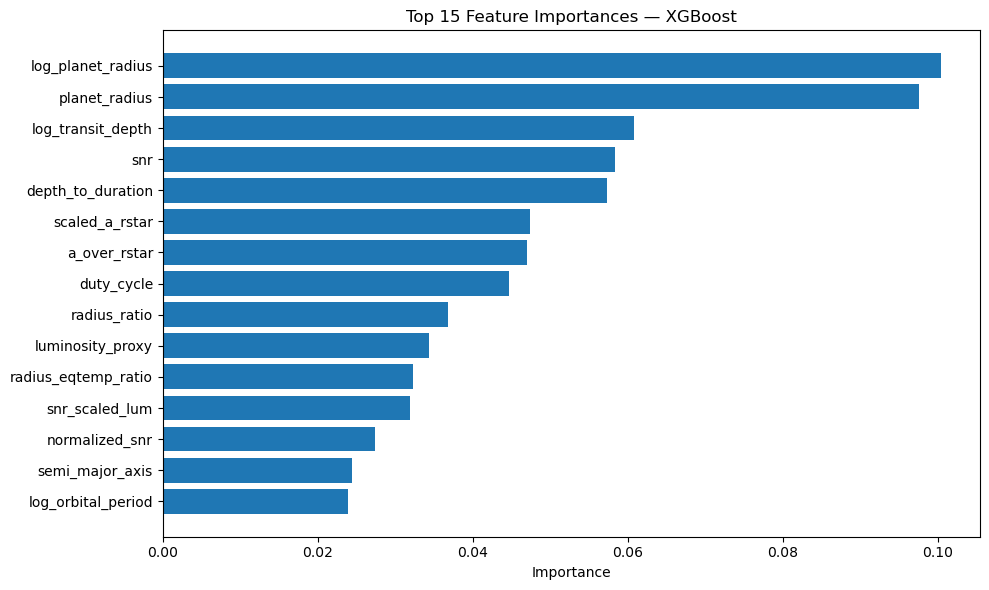


💾 Model and LabelEncoder saved to 'model/' directory
🎯 F1-Score (Macro): 0.7511
🎯 F1-Score (Weighted): 0.7547
🎯 Precision (Macro): 0.7627
🎯 Recall (Macro): 0.7441

📊 F1-Scores per class:
   CANDIDATE: 0.7558
   CONFIRMED: 0.7226
   FALSE POSITIVE: 0.7747


In [5]:
# =============================================================
# 🌌 NASA Space Apps Exoplanet Classifier — XGBoost Edition
# =============================================================

import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# -----------------------------
# Load Data
# -----------------------------
koi = pd.read_csv("KOI_data.csv")
toi = pd.read_csv("TOI_data.csv")
k2 = pd.read_csv("k2_data.csv")

# -----------------------------
# Rename Columns
# -----------------------------
koi.rename(columns={
    "koi_period": "orbital_period", "koi_duration": "transit_duration",
    "koi_depth": "transit_depth", "koi_prad": "planet_radius",
    "koi_sma": "semi_major_axis", "koi_impact": "impact",
    "koi_steff": "star_temp", "koi_srad": "star_radius",
    "koi_slogg": "star_gravity", "koi_model_snr": "snr",
    "koi_disposition": "disposition"
}, inplace=True)

toi.rename(columns={
    "pl_orbper": "orbital_period", "pl_trandurh": "transit_duration",
    "pl_trandep": "transit_depth", "pl_rade": "planet_radius",
    "st_teff": "star_temp", "st_rad": "star_radius",
    "st_logg": "star_gravity", "tfopwg_disp": "disposition"
}, inplace=True)

k2.rename(columns={
    "pl_orbper": "orbital_period", "pl_trandur": "transit_duration",
    "pl_trandep": "transit_depth", "pl_rade": "planet_radius",
    "pl_orbsmax": "semi_major_axis", "pl_imppar": "impact",
    "st_teff": "star_temp", "st_rad": "star_radius",
    "st_logg": "star_gravity"
}, inplace=True)

# -----------------------------
# Disposition Mappings
# -----------------------------
toi["disposition"] = toi["disposition"].map({
    "CP": "CONFIRMED", "KP": "CONFIRMED", "PC": "CANDIDATE",
    "APC": "CANDIDATE", "FP": "FALSE POSITIVE"
})
k2["disposition"] = k2["disposition"].map({"REFUTED": "FALSE POSITIVE"})

# -----------------------------
# Feature Engineering
# -----------------------------
teff_sun = 5227  # K

# Semi-major axis if missing in TOI
toi["semi_major_axis"] = (toi["star_radius"] * ((toi["star_temp"] / teff_sun) ** 2)) / np.sqrt(toi["pl_insol"])

# Impact approximation
a_over_rstar = 5 * (toi["orbital_period"] / 3) ** (2 / 3)
T_total_days = toi["transit_duration"] / 24
term = (np.pi * T_total_days / toi["orbital_period"]) * a_over_rstar
term = term.clip(0, 1)
toi["impact"] = np.sqrt(np.clip(1 - term**2, 0, None)).round(3)

# SNR calculation
toi["snr"] = (toi["transit_depth"] / (60 * 10 ** (0.2 * (toi["st_tmag"] - 10)))) \
             * np.sqrt(np.clip(27 / toi["orbital_period"], 0, 100))
toi["snr"] = toi["snr"].round(1)
k2["snr"] = k2["transit_depth"] * 100 * 10 * np.sqrt(np.clip(80 / k2["orbital_period"], 0, None))
k2["snr"] = k2["snr"].round(1)

# Features of interest
features = [
    "orbital_period", "transit_duration", "transit_depth", "planet_radius",
    "semi_major_axis", "impact", "star_temp", "star_radius",
    "star_gravity", "snr", "disposition"
]

k2 = k2.loc[k2["discoverymethod"] == "Transit", features]
koi = koi.loc[:, features]
toi = toi.loc[:, features]

data = pd.concat([k2, koi, toi], ignore_index=True)

# Additional feature engineering
data["radius_ratio"] = data["planet_radius"] / data["star_radius"]
data["a_over_rstar"] = data["semi_major_axis"] / data["star_radius"]
data["transit_signal"] = data["transit_depth"] * np.sqrt(data["transit_duration"])
data["star_density_proxy"] = data["star_gravity"] / data["star_radius"]

for col in ["orbital_period", "transit_depth", "planet_radius"]:
    data[f"log_{col}"] = np.log1p(data[col])

data["duty_cycle"] = data["transit_duration"] / data["orbital_period"]
data["normalized_depth"] = data["transit_depth"] / (data["star_radius"]**2)
data["luminosity_proxy"] = (data["star_radius"]**2) * (data["star_temp"]**4)
data["depth_to_duration"] = data["transit_depth"] / data["transit_duration"]
data["snr_per_duration"] = data["snr"] / data["transit_duration"]
data["log_luminosity"] = np.log1p(data["luminosity_proxy"])
data["scaled_a_rstar"] = data["semi_major_axis"] / data["star_radius"]
data["normalized_snr"] = data["snr"] / np.sqrt(data["orbital_period"])
data["luminosity_star"] = (data["star_radius"] ** 2) * (data["star_temp"] / 5778) ** 4
data["eq_temp"] = data["star_temp"] * np.sqrt(data["star_radius"] / (2 * data["semi_major_axis"])) * ((1 - 0.3) ** 0.25)
data["insolation_flux"] = (data["luminosity_star"]) / (data["semi_major_axis"] ** 2)
data["snr_scaled_lum"] = data["snr"] / np.sqrt(data["luminosity_star"])
data["depth_temp_ratio"] = data["transit_depth"] / data["star_temp"]
data["radius_eqtemp_ratio"] = data["planet_radius"] / np.sqrt(data["eq_temp"])

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data["duty_cycle"].clip(upper=1, inplace=True)
data.dropna(axis=1, how="all", inplace=True)

# -----------------------------
# Prepare features and labels
# -----------------------------
data = data.dropna(subset=["disposition"])
num_features = [c for c in data.columns if c != "disposition"]
X = data[num_features]
y = data["disposition"]

# Label encoding
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# -----------------------------
# Preprocessing pipeline
# -----------------------------
num_pipeline = Pipeline([
    ("imputer", IterativeImputer(initial_strategy="median", random_state=0, max_iter=30)),
    ("fallback", SimpleImputer(strategy="constant", fill_value=0)),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features)
])

# XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=600,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    reg_alpha=0.1,
    min_child_weight=5,
    gamma=0.1,
    objective="multi:softmax",
    eval_metric="mlogloss",
    tree_method="hist",
    device="cpu",
    random_state=42
)

clf = Pipeline([
    ("preprocessor", preprocessor),
    ("var_thresh", VarianceThreshold(threshold=0.0)),
    ("classifier", xgb_model)
])

# -----------------------------
# Train/Test split
# -----------------------------
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# -----------------------------
# Train model
# -----------------------------
clf.fit(X_train, y_train)

# -----------------------------
# Evaluation
# -----------------------------
y_pred = clf.predict(X_valid)
print(f"\n🏋️ Training Accuracy: {accuracy_score(y_train, clf.predict(X_train)):.4f}")
print(f"🎯 Validation Accuracy: {accuracy_score(y_valid, y_pred):.4f}")
print(f"🏋️ Training Balanced Accuracy: {balanced_accuracy_score(y_train, clf.predict(X_train)):.4f}")
print(f"🎯 Validation Balanced Accuracy: {balanced_accuracy_score(y_valid, y_pred):.4f}")
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_valid, y_pred))
print("\n✅ Classification Report:\n", classification_report(y_valid, y_pred, target_names=encoder.classes_))

# -----------------------------
# Feature Importance Plot
# -----------------------------
importances = xgb_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(np.array(num_features)[sorted_idx][:15][::-1], importances[sorted_idx][:15][::-1])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances — XGBoost")
plt.tight_layout()
plt.show()

# -----------------------------
# Save model and encoder
# -----------------------------
joblib.dump(clf, "xgb_model.pkl")
joblib.dump(encoder, "xgb_label_encoder.pkl")
print("\n💾 Model and LabelEncoder saved to 'model/' directory")

# Add this after your existing metrics in train_model.py
f1_macro = f1_score(y_valid, y_pred, average='macro')
f1_weighted = f1_score(y_valid, y_pred, average='weighted')
f1_per_class = f1_score(y_valid, y_pred, average=None)

precision_macro = precision_score(y_valid, y_pred, average='macro')
recall_macro = recall_score(y_valid, y_pred, average='macro')

print(f"🎯 F1-Score (Macro): {f1_macro:.4f}")
print(f"🎯 F1-Score (Weighted): {f1_weighted:.4f}")
print(f"🎯 Precision (Macro): {precision_macro:.4f}")
print(f"🎯 Recall (Macro): {recall_macro:.4f}")

print("\n📊 F1-Scores per class:")
for i, class_name in enumerate(encoder.classes_):
    print(f"   {class_name}: {f1_per_class[i]:.4f}")
